# Music recommendation system
<br>
Based on the Cameron Wolfe's work:<br>
https://towardsdatascience.com/building-a-music-recommendation-engine-with-probabilistic-matrix-factorization-in-pytorch-7d2934067d4a <br>
https://github.com/wolfecameron/music_recommendation <br>
<br>
Used dataset of last.fm users released in the framework of Het Rec2011:<br>
http://files.grouplens.org/datasets/hetrec2011/ <br>
<br>
The system was built using Pytorch framework. The main idea behind the system is Matrix factorization.

In [1]:
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

## 1. Explanatory Data Analysis
<br>
In this work I used only statistics of users' flavours for certain artists. I did not used available information about users' frendship and music tags.<br>
The dataset is contained in a .dat file, which is in its structure a simple tab-separated values file.<br>
Each line contains a pair userID-artistID and 'weight' which is number of minutes this user listened to the music of this artist.

In [2]:
user_artist = pd.read_csv("data/hetrec2011-lastfm-2k/user_artists.dat", sep='\t')
user_artist.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [3]:
print("Total records: {0}".format(user_artist['userID'].count()))
print("Total users: {0}".format(user_artist['userID'].nunique()))
print("Total artists: {0}".format(user_artist['artistID'].nunique()))
print("Known ratings ratio: {0:.2%}".format(user_artist['userID'].count() / 
                                            (user_artist['userID'].nunique() * user_artist['artistID'].nunique())))

Total records: 92834
Total users: 1892
Total artists: 17632
Known ratings ratio: 0.28%


The user-artist matrix is very sparse, only as little as 0.28% of possible ratings are known, which is not too surprising.

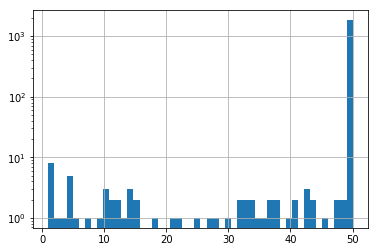

In [4]:
user_artist.userID.value_counts().hist(bins=50)
plt.yscale("log")
plt.show()

The dataset presents 50 most popular artists for each user, and if user listened to less then 50 artists on the last.fm, then it present as much as possible. As can be seen from the plot above, the vast majority of presented users have the full list of 50 top artists in the dataset. <br>
It is very hard to understand flavours of a user with a short listening history, but fortunately, the number of such users is relatively small.

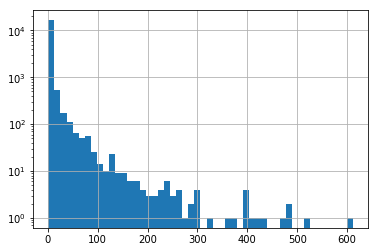

In [5]:
user_artist.artistID.value_counts().hist(bins=50)
plt.yscale("log")
plt.show()

On the other hand, most presented artists had been listened to by only 1 user. Such artists are very hard to recommend, because info from a single user is not robust. And moreover, it's not possible to test the model upon such artists, because if we use these records for training - there is no sense in testing on them, and if we don't - the predictions will be fully random.

## 2. Data preparation
<br>
Let us get rid of users which listened little artists as well as from not well-rated artists.

In [6]:
MIN_RATED_ARTISTS_PER_USER = 40
MIN_RATINGS_FOR_ARTIST = 5
user_artist_filtered = user_artist.drop(
    user_artist[
        (user_artist.userID.value_counts()[user_artist.userID] < MIN_RATED_ARTISTS_PER_USER).values |\
        (user_artist.artistID.value_counts()[user_artist.artistID] < MIN_RATINGS_FOR_ARTIST).values
    ].index
)
user_artist_filtered.count()

userID      70881
artistID    70881
weight      70881
dtype: int64

Thus we dropped around 20k records, but it will lead to decreasing sparseness of the user-artist data, making our model more trustworthy.<br>
As a second turn, let us remap the ID's in the dataset to make them continious. We will save the remapping dictionaries in order to revert the changes after our work, so the numbers may match the actual users and artists.

In [7]:
def reverse_dict(x):
    return dict(zip(x.values(), x.keys()))

user_remap = dict(enumerate(user_artist_filtered.userID.unique()))
artist_remap = dict(enumerate(user_artist_filtered.artistID.unique()))

user_artist_rm = pd.DataFrame()
user_artist_rm['userID'] = user_artist_filtered.userID.map(reverse_dict(user_remap))
user_artist_rm['artistID'] = user_artist_filtered.artistID.map(reverse_dict(artist_remap))
user_artist_rm['weight'] = user_artist_filtered['weight']
user_artist_rm.head()

,userID,artistID,weight
0,0,0,13883
1,0,1,11690
2,0,2,11351
3,0,3,10300
4,0,4,8983


Simple random splitting to train and test sets is not applicable in this case. Because, for instance, if a user is not presented in the training dataset it is not possible to predict any of his flavours in the test.<br>
So I decided to take the 10% of users and try to predict 20% of their ratings.<br>
<br>
Weights in their current form have a little meaning, because if a person listened to any kind of music 10 times more than another person, it doesn't mean that she or he likes any artist 10 times more. This is why I renormalised the weigths based on the total listening time for each user in the training dataset.<br>
For the records in the test subset labels were derived using total listening times from training subset in order to simulate the actual case where we would like to recommend a person something new.

In [8]:
def data_split(data, test_users_ratio=0.1):
    test_users = np.random.choice(data['userID'].values, 
                                  size=round(test_users_ratio*data['userID'].nunique()))
    test_row_indeces = []
    for user in test_users:
        user_records = data.loc[data['userID'] == user, :].index.values
        test_row_indeces.extend(np.random.choice(user_records, size=round(0.2*user_records.size)).tolist())
    test = data.loc[test_row_indeces, :].sample(frac=1)
    train = data.drop(test_row_indeces, axis=0).sample(frac=1)
    return train, test

def renorm_weigth(row, user_total, artist_mean):
    return row['weight'] / user_total_time.at[row['userID']]


train, test = data_split(user_artist_rm)
user_total_time = train.weight.groupby(train['userID']).sum()
train['weight'] = train.apply(renorm_weigth, user_total=user_total_time, artist_mean=None, axis=1)
artist_mean_rating = train.weight.groupby(train['artistID']).mean()
test['weight'] = test.apply(renorm_weigth, user_total=user_total_time, artist_mean=artist_mean_rating, axis=1)

train.to_csv("data/music_train.csv", index=False)
test.to_csv("data/music_test.csv", index=False)

test.count()

userID      1510
artistID    1510
weight      1510
dtype: int64

## 3. Model building

At first, let us create dataloaders for feeding the model with minibatches of data during training.

In [9]:
# create a custom class to handle data sets for the recommendation data
from torch.utils import data


# method for shuffling data in a data frame so that ordering
# is random during training
def shuffle_data(path, filename):
    df = pd.read_csv(path + filename)
    df = df.sample(frac=1)
    df.to_csv(path + filename, index=False)

    
class RecDataset(data.Dataset):
    'Create custom class for pytorch data set'
    def __init__(self, path, file_name):
        'Initialization of data frame'
        self.data = pd.read_csv(path + file_name)

    def __len__(self):
        'find total number of samples'
        return self.data.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        # get data sample from the data set
        return (np.array(self.data.loc[index, :]))

    
def get_loader(path, filename, bs):
    """method for getting a data loader from a csv file"""
    shuffle_data(path, filename)
    data_set = RecDataset(path, filename)
    data_loader = data.DataLoader(data_set, batch_size=bs, num_workers=2)
    return data_loader


train_loader = get_loader('data/', "music_train.csv", 32)

Now it's time to describe the actual model we are going to implement. We would like to perform matrix factorization, obtaining two matrices, one for users and one for artists. Then we will be able to get a user's rating for an artist by multiplying the corresponding rows from user and artist matrices.<br>
In order to implement the described behaviour we will use torch.nn.Embedding class objects.

In [10]:
class Recommender(nn.Module):
    def __init__(self, num_users, num_artists, num_factors):
        super().__init__()
        self.u = nn.Embedding(num_users, num_factors)
        self.a = nn.Embedding(num_artists, num_factors)
        self.u.weight.data.uniform_(-0.01, 0.01)
        self.a.weight.data.uniform_(-0.01, 0.01)
        self.ub = nn.Embedding(num_users, 1)
        self.ab = nn.Embedding(num_artists, 1)
        self.ub.weight.data.uniform_(-0.01, 0.01)
        self.ab.weight.data.uniform_(-0.01, 0.01)
        
    def forward(self, cats, cots):
        users, artists = cats[:,0], cats[:,1]
        us, art = self.u(users), self.a(artists)
        dp = (us*art).sum(1)
        dpb = dp + self.ub(users).squeeze() + self.ab(artists).squeeze()
        return dpb

## 4. Training

Finished Training


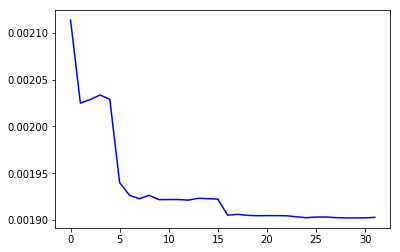

In [11]:
from torch.autograd import Variable as V
from torch import optim
from torch import from_numpy
from IPython import display

#flag activating progress printing after each epoche
LOG = False

# declare the size of embeddings to be used
num_factors = 40

# declare the weigths decay parameter for SGD
wd = 1e-3

# declare loss criterion for the model
criterion = nn.MSELoss()

# create model and optimizer
recommender_model = Recommender(
    num_users=user_artist_rm.userID.nunique(),
    num_artists=user_artist_rm.artistID.nunique(),
    num_factors=num_factors
).cuda()

training_loss = []
lr = .1

min_loss = 10.0
epoch_to_lower = 3
eps = 1e-7

while(lr > 1e-5):
    
    opt = optim.SGD(recommender_model.parameters(), lr, weight_decay=wd, momentum=0.9)
    epoch = 0
    epoch_no_improve = 0
    while(True):  # loop over the dataset multiple times

        train_loader = get_loader("data/", "music_train.csv", 32)
        running_loss = 0.0
        for i, train_data in enumerate(train_loader):
            # get the inputs
            inputs = train_data[:, :2].long().cuda()
            actual_out = V(train_data[:, 2].float()).cuda()

            # zero the parameter gradients
            opt.zero_grad()

            # forward + backward + optimize
            outputs = recommender_model.forward(inputs, None)
            loss = criterion(outputs, actual_out)
            loss.backward()
            opt.step()

            running_loss += loss.item()
                
        epoch += 1
        training_loss.append((running_loss/len(train_loader)))
        if LOG:
            print(f"[{lr:.0e}, {epoch}] loss: {running_loss/len(train_loader)}")
        else:
            plt.clf()
            plt.plot(training_loss, c='b')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        if running_loss/len(train_loader) < min_loss - eps:
            epoch_no_improve = 0
            min_loss = running_loss/len(train_loader)
        else:
            epoch_no_improve += 1
            if epoch_no_improve >= epoch_to_lower:
                break
    lr *= .1
    

print('Finished Training')
if LOG:
    plt.plot(training_loss)
    plt.show()

## 5. Evaluating

Validation MSE: 0.004858031596086221


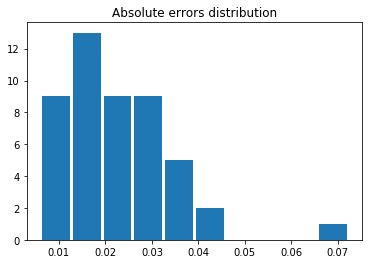

In [21]:
running_loss = 0.0
abs_errors = []
criterion2 = nn.L1Loss()
test_loader = get_loader("data/", 'music_test.csv', 32)
for i, test_data in enumerate(test_loader):
    inputs = test_data[:, :2].long().cuda()
    actual_out = V(test_data[:, 2].float()).cuda()
    # get prediction from recommender
    pred = recommender_model(inputs, None)
    loss = criterion(pred, actual_out)
    abs_errors.append(criterion2(pred, actual_out).item())
    running_loss += loss.item()

print(f"Validation MSE: {running_loss/len(test_loader)}")
plt.hist(abs_errors, rwidth=.9, density=False)
plt.title("Absolute errors distribution")
plt.show()

Now let us revert the remappings done in the 2nd section of this notebook and find out which artists turned out to be the most popular.

In [22]:
np_artist_embedding = recommender_model.ab.weight.data.cpu().numpy()
artist_embedding = pd.DataFrame(np_artist_embedding).rename({0:'weight'}, axis=1)
artist_embedding['artistID'] = artist_embedding.index.map(artist_remap)
artist_embedding.set_index('artistID', drop=True, inplace=True)
artists = pd.read_csv("data/hetrec2011-lastfm-2k/artists.dat", sep='\t', usecols=['id', 'name']).set_index('id', drop=False)
artists = artist_embedding.join(artists).drop('id', axis=1)
artists.sort_values('weight', ascending=False).head(10)

,weight,name
artistID,,
72,0.091709,Depeche Mode
289,0.076234,Britney Spears
2044,0.056700,Sarah Brightman
89,0.044960,Lady Gaga
51,0.044496,Duran Duran
917,0.040031,Iron Maiden
292,0.039445,Christina Aguilera
227,0.038996,The Beatles
344,0.035776,Taylor Swift
